In [55]:
import xarray as xr
import numpy as np
import xradar as xd
import cmweather
import matplotlib.pyplot as plt

In [35]:
ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/barg/parsivel/*.nc')
ds

<xarray.Dataset> Size: 180MB
Dimensions:    (time: 467914, bins: 32, bin_edges: 33)
Coordinates:
  * time       (time) float64 4MB 1.717e+09 1.717e+09 ... 1.722e+09 1.722e+09
  * bin_edges  (bin_edges) float64 264B 0.0 0.1245 0.2545 ... 20.6 23.7 26.78
Dimensions without coordinates: bins
Data variables: (12/16)
    Nd         (time, bins) float64 120MB dask.array<chunksize=(1519, 32), meta=np.ndarray>
    Zh         (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    Zdr        (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    delta_co   (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    Kdp        (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    Ai         (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    ...         ...
    Nt         (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    Nw         (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    N0         (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    W          (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    mu         (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>
    Lambda     (time) float64 4MB dask.array<chunksize=(1519,), meta=np.ndarray>

In [36]:
ds["time"] = np.array(ds["time"], dtype='datetime64[s]')

/tmp/ipykernel_1282268/328852630.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds["time"] = np.array(ds["time"], dtype='datetime64[s]')
/tmp/ipykernel_1282268/328852630.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the v

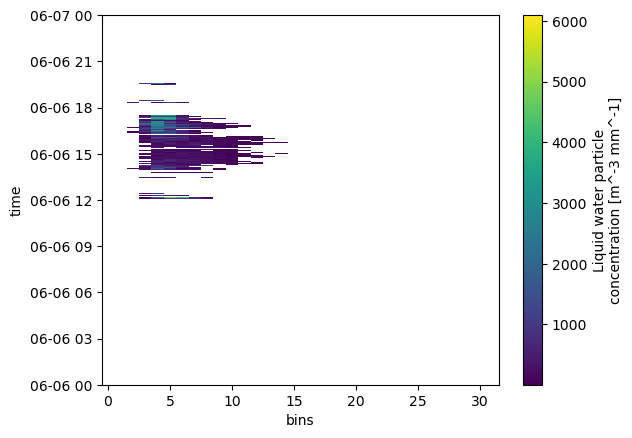

In [13]:
ds["Nd"].sel(time=slice(np.datetime64("2024-06-06T00:00:00", 's'), "2024-06-07T00:00:00")).plot()

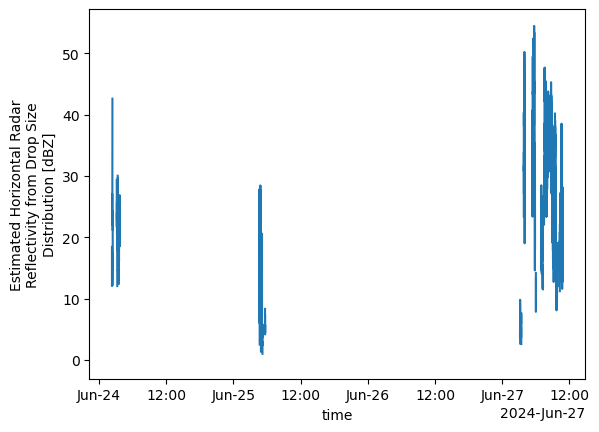

In [115]:
ds["Zh"].sel(time=slice("2024-06-24T00:00:00", "2024-06-28T00:00:00")).plot()

## June 6 - light rain
June 9 - heavier rain
June 24 - light rain
June 27 - heavy rain

In [116]:
ds_mrr = xr.open_dataset(
    '/lcrc/group/earthscience/rjackson/wfip3/barg/mrr/barg.mrr.z01.a0.20240627.000000.nc')


In [117]:
ds_mrr

<xarray.Dataset> Size: 323MB
Dimensions:                      (sample: 64, time: 6499, range: 31,
                                  index: 201447)
Coordinates:
    velocity_bins                (sample) float64 512B ...
  * range                        (range) float64 248B 150.0 300.0 ... 4.65e+03
  * time                         (time) datetime64[ns] 52kB 2024-06-27T00:00:...
Dimensions without coordinates: sample, index
Data variables: (12/17)
    transfer_function            (time, range) float64 2MB ...
    spectral_reflectivity        (index, sample) float64 103MB ...
    drop_size                    (index, sample) float64 103MB ...
    drop_number_density          (index, sample) float64 103MB ...
    percentage_valid_spectra     (time) float64 52kB ...
    path_integrated_attenuation  (time, range) float64 2MB ...
    ...                           ...
    altitude                     float64 8B ...
    longitude                    float64 8B ...
    latitude                     float64 8B ...
    spectrum_index               (time, range) float64 2MB ...
    azimuth                      (time) float64 52kB ...
    elevation                    (time) float64 52kB ...

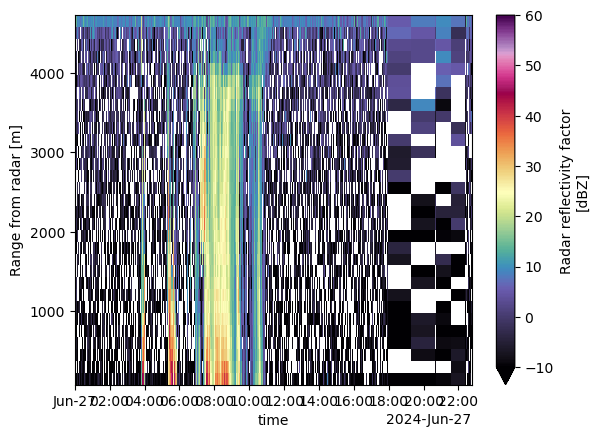

In [118]:
ds_mrr['reflectivity'].T.plot(cmap='ChaseSpectral', vmin=-10, vmax=60)

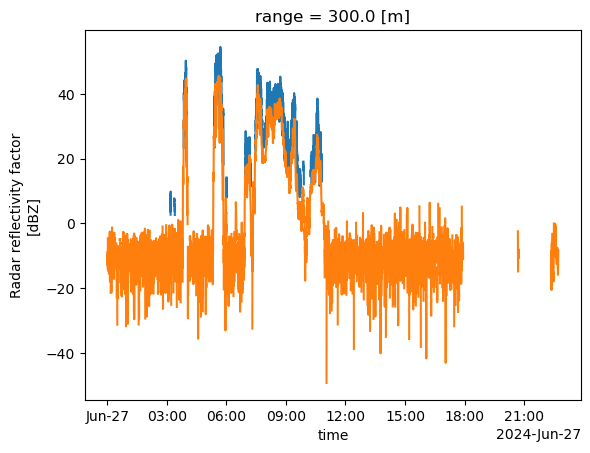

In [119]:
ds["Zh"].sel(time=slice("2024-06-27T00:00:00", "2024-06-28T00:00:00")).plot()
ds_mrr["reflectivity"].isel(range=1).plot()

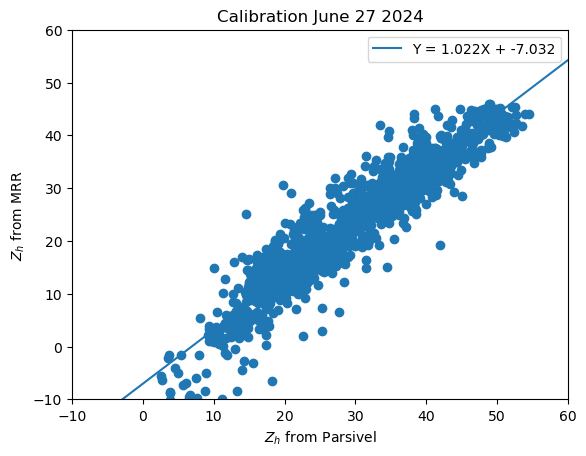

In [124]:
Zh_parsivel = ds["Zh"].sel(time=slice("2024-06-27T00:00:00", "2024-06-28T00:00:00")).reindex(time=ds_mrr.time,
                                                                                             method='nearest').values
D0_June6 = ds["Dm"].sel(time=slice("2024-06-27T00:00:00", "2024-06-28T00:00:00")).reindex(time=ds_mrr.time,
                                                                                             method='nearest',
                                                                                             tolerance=np.timedelta64(60, 's')).values
Zh_mrr = ds_mrr["corrected_reflectivity"].isel(range=1).values
inds = np.logical_and(np.isfinite(Zh_mrr), np.isfinite(Zh_parsivel))
inds = np.logical_and(inds, D0_June6 > 0)
fit = np.polyfit(Zh_parsivel[inds], Zh_mrr[inds], 1)
plt.scatter(Zh_parsivel[inds], Zh_mrr[inds],)
plt.xlim([-10, 60])
plt.ylim([-10, 60])
plt.xlabel('$Z_{h}$ from Parsivel')
plt.ylabel('$Z_{h}$ from MRR')
plt.plot([-10, 60], np.polyval(fit, [-10, 60]), label='Y = %2.3fX + %2.3f' % (fit[0], fit[1]))
plt.legend()
plt.title('Calibration June 27 2024')
plt.savefig('MRR_Cal_June27.png')

In [101]:
N0_June6 = ds["Nw"].sel(time=slice("2024-06-06T00:00:00", "2024-06-07T00:00:00")).values
N0_June9 = ds["Nw"].sel(time=slice("2024-06-09T00:00:00", "2024-06-10T00:00:00")).values
D0_June6 = ds["Dm"].sel(time=slice("2024-06-06T00:00:00", "2024-06-07T00:00:00")).values
D0_June9 = ds["Dm"].sel(time=slice("2024-06-09T00:00:00", "2024-06-10T00:00:00")).values

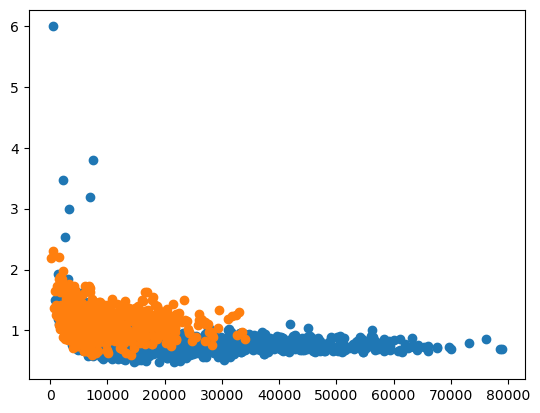

In [96]:
plt.scatter(N0_June6, D0_June6)
plt.scatter(N0_June9, D0_June9)

In [139]:
days = ["20240606", "20240609", "20240624", "20240627"]
Ze_mrr = []
Ze_parsivel = []
for day in days:
    ds_mrr = xr.open_dataset(
        '/lcrc/group/earthscience/rjackson/wfip3/barg/mrr/barg.mrr.z01.a0.%s.000000.nc' % day)
    Zh_mrr = ds_mrr["corrected_reflectivity"].isel(range=1).values
    year = day[0:4]
    month = day[4:6]
    daynum = day[6:8]
    Zh_parsivel = ds["Zh"].sel(time=slice("%s-%s-%sT00:00:00" % (year, month, daynum),
                                          "%s-%s-%sT23:59:59" % (year, month, daynum))).resample(time='60s').mean().reindex(time=ds_mrr.time, method='nearest').values
    Ze_mrr.append(Zh_mrr)
    Ze_parsivel.append(Zh_parsivel)
    ds_mrr.close()
    
Ze_mrr = np.concatenate(Ze_mrr)
Ze_parsivel = np.concatenate(Ze_parsivel)
    

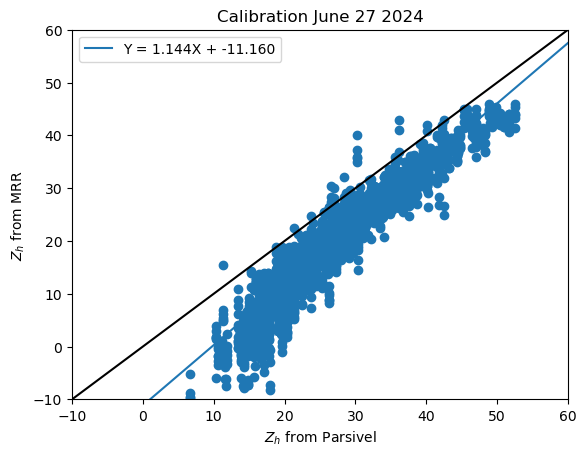

In [140]:
inds = np.logical_and(Ze_mrr > -10, Ze_parsivel > -10)
#inds = np.logical_and(inds, D0_June6 > 0)
fit = np.polyfit(Ze_parsivel[inds], Ze_mrr[inds], 1)
plt.scatter(Ze_parsivel[inds], Ze_mrr[inds],)
plt.xlim([-10, 60])
plt.ylim([-10, 60])
plt.xlabel('$Z_{h}$ from Parsivel')
plt.ylabel('$Z_{h}$ from MRR')
plt.plot([-10, 60], np.polyval(fit, [-10, 60]), label='Y = %2.3fX + %2.3f' % (fit[0], fit[1]))
plt.plot([-10, 60], [-10, 60], color='k')
plt.legend()
plt.title('Calibration June 27 2024')
plt.savefig('MRR_Cal_June27.png')

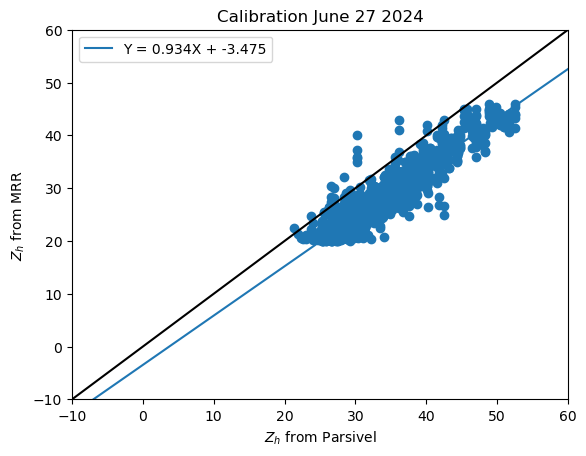

In [142]:
inds = np.logical_and(Ze_mrr > 20, Ze_parsivel > 20)
#inds = np.logical_and(inds, D0_June6 > 0)
fit = np.polyfit(Ze_parsivel[inds], Ze_mrr[inds], 1)
plt.scatter(Ze_parsivel[inds], Ze_mrr[inds],)
plt.xlim([-10, 60])
plt.ylim([-10, 60])
plt.xlabel('$Z_{h}$ from Parsivel')
plt.ylabel('$Z_{h}$ from MRR')
plt.plot([-10, 60], np.polyval(fit, [-10, 60]), label='Y = %2.3fX + %2.3f' % (fit[0], fit[1]))
plt.plot([-10, 60], [-10, 60], color='k')
plt.legend()
plt.title('Calibration June 27 2024')
plt.savefig('MRR_Cal_June27_gt20.png')

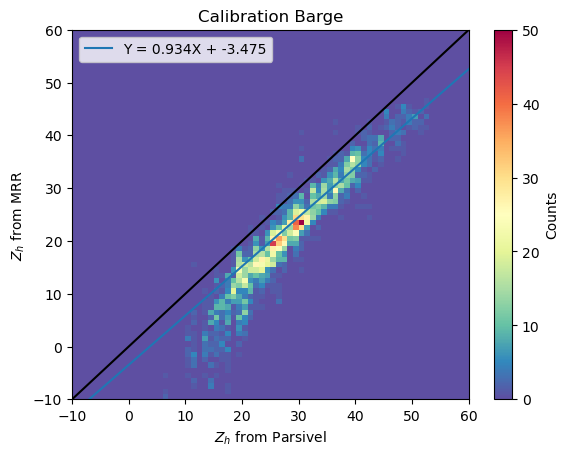

In [163]:
inds = np.logical_and(Ze_mrr > -10, Ze_parsivel > -10)
#inds = np.logical_and(inds, D0_June6 > 0)
Ze_bins = np.arange(-10, 61, 1)
hist = np.histogram2d(Ze_parsivel[inds], Ze_mrr[inds], bins=Ze_bins)
#fit = np.polyfit(Ze_parsivel[inds], Ze_mrr[inds], 1)
c = plt.pcolormesh(Ze_bins, Ze_bins, hist[0].T, cmap="Spectral_r")
plt.colorbar(c, label='Counts')
plt.xlim([-10, 60])
plt.ylim([-10, 60])
plt.xlabel('$Z_{h}$ from Parsivel')
plt.ylabel('$Z_{h}$ from MRR')
plt.plot([-10, 60], np.polyval(fit, [-10, 60]), label='Y = %2.3fX + %2.3f' % (fit[0], fit[1]))
plt.plot([-10, 60], [-10, 60], color='k')
plt.legend()
plt.title('Calibration Barge')
plt.savefig('MRR_Cal_June27_gt20.png')

/tmp/ipykernel_1282268/4233546519.py:8: RuntimeWarning: Mean of empty slice
  bias[i] = np.nanmean(Ze_mrr[inds_range] - Ze_parsivel[inds_range])
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


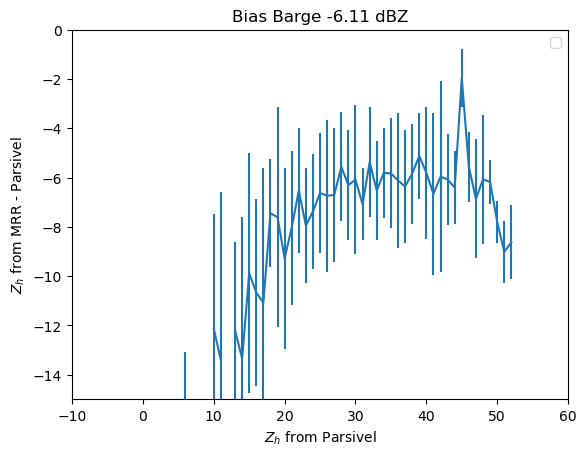

In [165]:
inds = np.logical_and(Ze_mrr > -10, Ze_parsivel > -10)
#inds = np.logical_and(inds, D0_June6 > 0)
Ze_bins = np.arange(-10, 61, 1)
bias = np.zeros(len(Ze_bins-1))
std = np.zeros(len(Ze_bins-1))
for i in range(len(Ze_bins)-1):
    inds_range = np.logical_and(Ze_parsivel >= Ze_bins[i], Ze_parsivel < Ze_bins[i+1])
    bias[i] = np.nanmean(Ze_mrr[inds_range] - Ze_parsivel[inds_range])
    std[i] = np.nanstd(Ze_mrr[inds_range] - Ze_parsivel[inds_range])
    
#fit = np.polyfit(Ze_parsivel[inds], Ze_mrr[inds], 1)
plt.errorbar(Ze_bins, bias, std)
plt.xlim([-10, 60])
plt.ylim([-15, -0])
plt.xlabel('$Z_{h}$ from Parsivel')
plt.ylabel('$Z_{h}$ from MRR - Parsivel')
plt.legend()
bias25_40 = np.mean(bias[np.logical_and(Ze_bins > 25, Ze_bins < 40)])
plt.title('Bias Barge %3.2f dBZ' % bias25_40)
plt.savefig('MRR_Cal_bias.png')


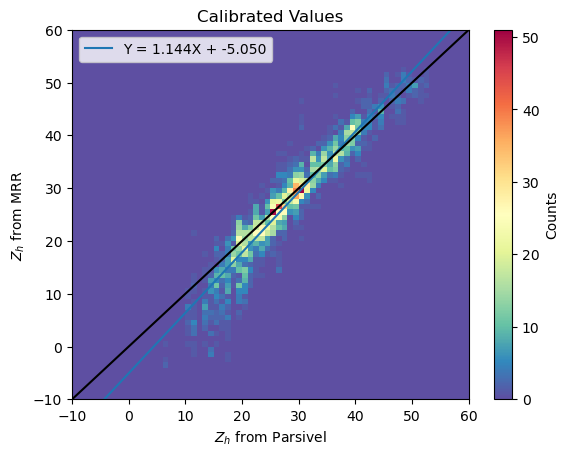

In [167]:
inds = np.logical_and(Ze_mrr > -10, Ze_parsivel > -10)
#inds = np.logical_and(inds, D0_June6 > 0)
Ze_bins = np.arange(-10, 61, 1)
hist = np.histogram2d(Ze_parsivel[inds], Ze_mrr[inds]+6.11, bins=Ze_bins)
fit = np.polyfit(Ze_parsivel[inds], Ze_mrr[inds]+6.11, 1)
c = plt.pcolormesh(Ze_bins, Ze_bins, hist[0].T, cmap="Spectral_r")
plt.colorbar(c, label='Counts')
plt.xlim([-10, 60])
plt.ylim([-10, 60])
plt.xlabel('$Z_{h}$ from Parsivel')
plt.ylabel('$Z_{h}$ from MRR')
plt.plot([-10, 60], np.polyval(fit, [-10, 60]), label='Y = %2.3fX + %2.3f' % (fit[0], fit[1]))
plt.plot([-10, 60], [-10, 60], color='k')
plt.legend()
plt.title('Calibrated Values')
plt.savefig('MRR_Cal_June27_calibrated.png')